In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import cv2
from imagen2 import Imagen

In [2]:
class Panorama:
    def __init__( self, path, ratioMascara=0.5 ):
        self.shape = (0, 0, 0)
        self.path = path
        self.offsetROI = 0
        self.ratioMascara = ratioMascara
        self.features = None
        self.keypoints = None

    def pegar( self, imagenAPegar, roi=None ):
        if self.shape == (0,0,0):
            panorama = np.memmap(self.path, dtype=np.uint8, mode='w+', shape=imagenAPegar.shape)
            panorama[:] = imagenAPegar.imagen[:]
            self.shape = imagenAPegar.shape
            self.offsetROI = int(self.shape[0] * self.ratioMascara)
        
        else: #supongo que imagen a pegar tiene mismo ancho que panorama, ya fue transformada, y tiene alto apropiado
            
            offset = self.offsetROI * self.shape[1] * self.shape[2]
            panorama = np.memmap(self.path, dtype=np.uint8, mode='r+', offset=offset, shape=imagenAPegar.shape)
            mascaraRegionPegado = cv2.bitwise_not(imagenAPegar.mascara)
            # le borro donde pego la otra imagen
            panorama[:] = cv2.bitwise_and( panorama, panorama, mask=mascaraRegionPegado)
            panorama[:] = cv2.add( panorama, imagenAPegar.imagen, dst=panorama)
            self.shape = (
                self.offsetROI + imagenAPegar.shape[0],
                self.shape[1],
                self.shape[2]
            )
            offsetX = (roi[3][1] - roi[0][1]) / 2
            self.offsetROI = int(self.offsetROI + offsetX)
            
    def getImage( self ):
        return np.memmap(self.path, dtype=np.uint8, mode='r', shape=self.shape)
        
    def getROI( self ):
        return np.memmap(self.path, dtype=np.uint8, mode='r', offset=self.offsetROI * self.shape[1] * self.shape[2], shape=(self.shape[0] - self.offsetROI, self.shape[1], self.shape[2]))
    

In [3]:
def fittear( ptData, ptTrain ):
    return np.float32( [
        [1, 0, ptTrain[0] - ptData[0]],
        [0, 1, ptTrain[1] - ptData[1]],
        [0, 0, 1]
    ] )

def calcularInliers( ptsData, ptsTrain, H, tolerancia):
    ptsData = np.block([ ptsData, np.ones( ( ptsData.shape[0], 1 )) ])
    ptsTrain = np.block([ ptsTrain, np.ones( ( ptsTrain.shape[0], 1 )) ])
    E = H@ptsData.T - ptsTrain.T

    return np.sum( [ np.dot( e,e ) < np.power(tolerancia, 2) for e in E.T  ] )

def matrizHomografica( ptsData, ptsTrain, tolerancia, maxIteraciones ):
    mejorFitteo = (np.eye(3), -np.inf) # matriz asociada y inliners
    for i in range(maxIteraciones):
        indiceInicial = np.random.randint(0, len(ptsData))
        H = fittear(ptsData[indiceInicial], ptsTrain[indiceInicial])
        cantInliers = calcularInliers(ptsData, ptsTrain, H, tolerancia)

        mejorFitteo = (H, cantInliers) if cantInliers > mejorFitteo[1] else mejorFitteo

    return mejorFitteo

def matchearImagenes(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras=None ):
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    if mascaras is None:
        rawMatches = matcher.knnMatch(imagenB.features, imagenA.features, 2)
    else:
        rawMatches = matcher.knnMatch(imagenB.getFeatures(mascaras[1]), imagenA.getFeatures(mascaras[0]), 2)
    matches = []
    
    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = matrizHomografica( ptsB, ptsA, tolerancia, maxIteracionesRansac)

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        
def stitchPar(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras=None):
    (matches, H, inliers) = matchearImagenes(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras)
    
    imagenB.mover(H[0][2], H[1][2])
    
    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        3
    )

    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor, np.zeros(resultShape[0:2], np.uint8) )
    result.pegar(imagenA)
    result.pegar(imagenB)

    return result


In [20]:
descriptor = cv2.xfeatures2d.SURF_create()
grilla = (6,4)
orden = [ i if int((i-1)/4) % 2 == 0 else 4*(int((i-1)/4)+1) - (i-1)%4 for i in range(1, grilla[0] * grilla[1] + 1)]

ratio = 0.75
tolerancia = 4
ratioMascaraW = 0.3
ratioMascaraH = 0.5
maxIteracionesRansac = 8
path = "panorama_3x4.nparr"

panorama = Panorama(path)

imagenes = deque(( Imagen( cv2.imread('Imagenes/Intestino curso/' + f"{i:02d}" + '.tif'), descriptor ) for i in orden ))
for fila in range(grilla[0]):
    imagenFila = imagenes.popleft()
    anchoUltimaPegada = imagenFila.shape[1]
    for col in range(grilla[1] - 1):
        imagenAPegar = imagenes.popleft()
        mascaras = [ 
            Imagen.crearMascara(imagenFila.shape, (anchoUltimaPegada * ratioMascaraW) / imagenFila.shape[1] if col != 0 else ratioMascaraW),
            Imagen.crearMascara(imagenAPegar.shape, ratioMascaraW, orden=1)
        ]
        anchoUltimaPegada = imagenAPegar.shape[1]
        imagenFila = stitchPar( imagenFila, imagenAPegar, ratio, tolerancia, maxIteracionesRansac, mascaras=mascaras )
    
    if panorama.shape == (0,0,0):
        panorama.pegar(imagenFila)

        panorama.features = imagenFila.getFeatures( Imagen.crearMascara(imagenFila.shape, ratioMascaraH, eje=1) )
        panorama.keypoints = imagenFila.keypoints - np.full_like( imagenFila.keypoints, [0, panorama.offsetROI ] )
    else:
        (matches, H, inliers) = matchearImagenes(panorama, imagenFila, ratio, tolerancia, maxIteracionesRansac)
        panorama.features = imagenFila.getFeatures( Imagen.crearMascara(imagenFila.shape, ratioMascaraH, eje=1) )
        panorama.keypoints = imagenFila.keypoints
        viejoOff = panorama.offsetROI

        roi = imagenFila.transformar(H, shape=( int( H[1][2] + imagenFila.shape[0] ), panorama.shape[1]))
        panorama.pegar(imagenFila, roi)

        H2 = np.array( [ [1, 0, H[0][2]], [0, 1, H[1][2] - (panorama.offsetROI - viejoOff)], [0, 0, 0] ])
        panorama.keypoints = (H2 @ np.vstack( [panorama.keypoints.T, np.ones(panorama.keypoints.shape[0])] ) ).T[:,0:2]


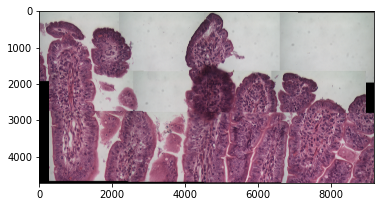

In [13]:
fullPano = np.memmap(panorama.path, dtype=np.uint8, mode='r', shape=panorama.shape)
plt.imshow(fullPano[...,::-1])

True

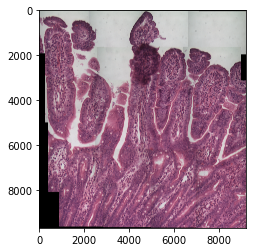

In [21]:

fullPano = np.memmap(panorama.path, dtype=np.uint8, mode='r', shape=panorama.shape)
plt.imshow(fullPano[...,::-1])
cv2.imwrite('ejemplos/intestino6x4.png', fullPano)
    